In [2]:
# Import necessary libraries
import nltk 
import torch
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt

# Downloading NLTK data (stopwords, wordnet, etc.)
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('stopwords', quiet=True)

# Importing text processing utilities from NLTK
from nltk.stem.porter import PorterStemmer  # For stemming words
from nltk.stem import WordNetLemmatizer  # For lemmatizing words

# String manipulation and regular expressions
import re
import string
import demoji  # For removing emojis from text


# WordCloud and text-related utilities
from wordcloud import WordCloud, STOPWORDS

# Importing ML and preprocessing libraries
import torch.nn as nn
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from torch.utils.data import WeightedRandomSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments


In [3]:
# Loading the dataset
data = pd.read_excel("C:/Users/aswal/Mental Health/complaints_scrapping.xlsx")

In [4]:
#Printing first five rows of the dataset
data.head()

,web-scraper-order,web-scraper-start-url,types,types-href,pages,complaints
0,1636362744-2938,https://counselchat.com/,Depression,https://counselchat.com/topics/anxiety,https://counselchat.com/topics/anxiety?page=18,How do I overcome my anxierty and depression?
1,1636361798-695,https://counselchat.com/,Addiction,https://counselchat.com/topics/addiction,https://counselchat.com/topics/addiction?page=5,How can I rebuild the trust I destroyed from m...
2,1636362079-1439,https://counselchat.com/,Depression,https://counselchat.com/topics/marriage,https://counselchat.com/topics/marriage?page=19,I'm going through depression right now and my ...
3,1636362291-1961,https://counselchat.com/,Relationship Dissolution,https://counselchat.com/topics/intimacy,https://counselchat.com/topics/intimacy?page=22,How do I talk to my girlfriend about my anxiet...
4,1636362128-1553,https://counselchat.com/,Relationship Dissolution,https://counselchat.com/topics/family-conflict,https://counselchat.com/topics/family-conflict...,My fiancé's ex-husband shows up unannounced


In [5]:
# Listing all the column names
data.columns

Index(['web-scraper-order', 'web-scraper-start-url', 'types', 'types-href',
       'pages', 'complaints'],
      dtype='object')

In [6]:
# Displaying dimensions of the dataset
print(data.shape)

(999, 6)


In [7]:
# Checking for missing values
data.isna().sum()  

web-scraper-order         0
web-scraper-start-url     0
types                     0
types-href                0
pages                    49
complaints                0
dtype: int64

In [8]:
# Checking for duplicates
data.duplicated().sum()  

0

In [9]:
# Displaying statistical summary of the dataset
data.describe()

,web-scraper-order,web-scraper-start-url,types,types-href,pages,complaints
count,999,999,999,999,950,999
unique,999,1,19,33,407,538
top,1636362744-2938,https://counselchat.com/,Relationship Dissolution,https://counselchat.com/topics/relationships,https://counselchat.com/topics/anger-managemen...,Do I have too many issues for counseling?
freq,1,999,240,156,6,29


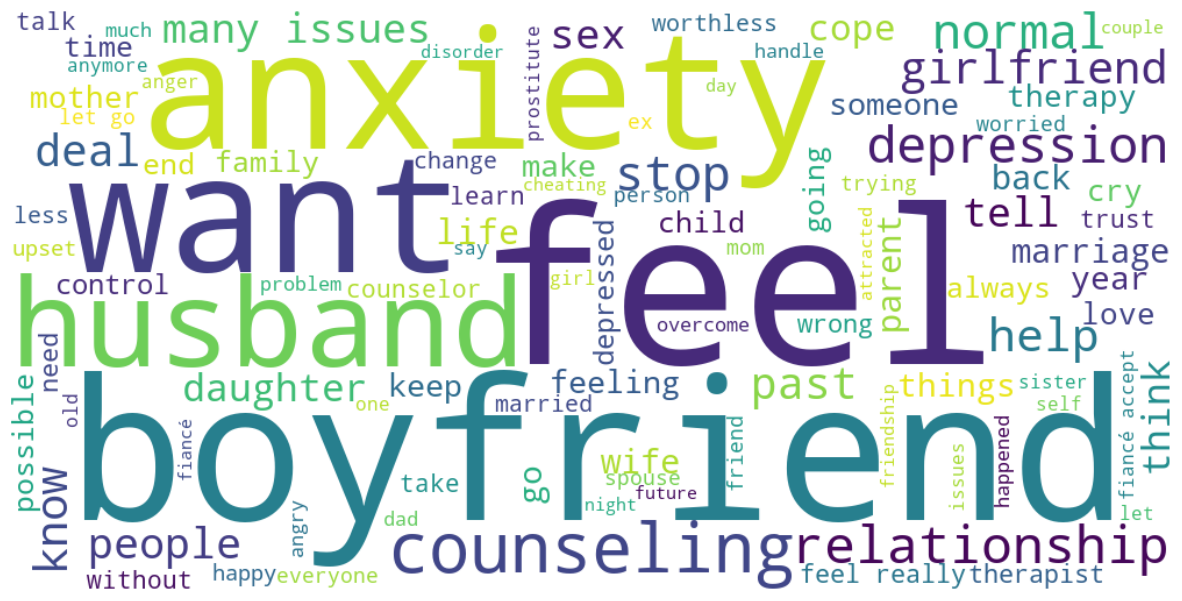

In [10]:
# Generating word cloud for the entire dataset
complaint = " ".join(i for i in data.complaints)
wordcloud = WordCloud(width=1000, height=500, background_color='white', stopwords=set(STOPWORDS), max_words=100).generate(complaint)
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [11]:
# Grouping the dataset by types and count occurrences
data.groupby(['types']).count()

,web-scraper-order,web-scraper-start-url,types-href,pages,complaints
types,,,,,
Abuse,4,4,4,4,4
Addiction,30,30,30,28,30
Anger Management,21,21,21,20,21
Anxiety,63,63,63,60,63
Behavioral Change,36,36,36,33,36
Career Guidance,2,2,2,2,2
Depression,131,131,131,127,131
Domestic Violence,9,9,9,9,9
Family Conflict,78,78,78,75,78


In [12]:
#Converting 'complaints' column to string type
data["complaints"] = data["complaints"].astype(str)

In [13]:
#Removing punctuations from the complaints
def remove_punctuation(text):
    return re.sub(r'[^\w\s]', '', text)

data['preprocessed_complaints'] = data['complaints'].apply(remove_punctuation)

data.head()


,web-scraper-order,web-scraper-start-url,types,types-href,pages,complaints,preprocessed_complaints
0,1636362744-2938,https://counselchat.com/,Depression,https://counselchat.com/topics/anxiety,https://counselchat.com/topics/anxiety?page=18,How do I overcome my anxierty and depression?,How do I overcome my anxierty and depression
1,1636361798-695,https://counselchat.com/,Addiction,https://counselchat.com/topics/addiction,https://counselchat.com/topics/addiction?page=5,How can I rebuild the trust I destroyed from m...,How can I rebuild the trust I destroyed from m...
2,1636362079-1439,https://counselchat.com/,Depression,https://counselchat.com/topics/marriage,https://counselchat.com/topics/marriage?page=19,I'm going through depression right now and my ...,Im going through depression right now and my r...
3,1636362291-1961,https://counselchat.com/,Relationship Dissolution,https://counselchat.com/topics/intimacy,https://counselchat.com/topics/intimacy?page=22,How do I talk to my girlfriend about my anxiet...,How do I talk to my girlfriend about my anxiet...
4,1636362128-1553,https://counselchat.com/,Relationship Dissolution,https://counselchat.com/topics/family-conflict,https://counselchat.com/topics/family-conflict...,My fiancé's ex-husband shows up unannounced,My fiancés exhusband shows up unannounced


In [14]:
# Converting complaints to lowercase
data['preprocessed_complaints'] = data['preprocessed_complaints'].str.lower()
data.head()

,web-scraper-order,web-scraper-start-url,types,types-href,pages,complaints,preprocessed_complaints
0,1636362744-2938,https://counselchat.com/,Depression,https://counselchat.com/topics/anxiety,https://counselchat.com/topics/anxiety?page=18,How do I overcome my anxierty and depression?,how do i overcome my anxierty and depression
1,1636361798-695,https://counselchat.com/,Addiction,https://counselchat.com/topics/addiction,https://counselchat.com/topics/addiction?page=5,How can I rebuild the trust I destroyed from m...,how can i rebuild the trust i destroyed from m...
2,1636362079-1439,https://counselchat.com/,Depression,https://counselchat.com/topics/marriage,https://counselchat.com/topics/marriage?page=19,I'm going through depression right now and my ...,im going through depression right now and my r...
3,1636362291-1961,https://counselchat.com/,Relationship Dissolution,https://counselchat.com/topics/intimacy,https://counselchat.com/topics/intimacy?page=22,How do I talk to my girlfriend about my anxiet...,how do i talk to my girlfriend about my anxiet...
4,1636362128-1553,https://counselchat.com/,Relationship Dissolution,https://counselchat.com/topics/family-conflict,https://counselchat.com/topics/family-conflict...,My fiancé's ex-husband shows up unannounced,my fiancés exhusband shows up unannounced


In [15]:
#Tokenizing the complaints
def simple_tokenize(text):
    if isinstance(text, str):
        return re.findall(r'\b\w+\b', text)
    else:
        return []

data['preprocessed_complaints'] = data['preprocessed_complaints'].apply(simple_tokenize)

data.head()


,web-scraper-order,web-scraper-start-url,types,types-href,pages,complaints,preprocessed_complaints
0,1636362744-2938,https://counselchat.com/,Depression,https://counselchat.com/topics/anxiety,https://counselchat.com/topics/anxiety?page=18,How do I overcome my anxierty and depression?,"[how, do, i, overcome, my, anxierty, and, depr..."
1,1636361798-695,https://counselchat.com/,Addiction,https://counselchat.com/topics/addiction,https://counselchat.com/topics/addiction?page=5,How can I rebuild the trust I destroyed from m...,"[how, can, i, rebuild, the, trust, i, destroye..."
2,1636362079-1439,https://counselchat.com/,Depression,https://counselchat.com/topics/marriage,https://counselchat.com/topics/marriage?page=19,I'm going through depression right now and my ...,"[im, going, through, depression, right, now, a..."
3,1636362291-1961,https://counselchat.com/,Relationship Dissolution,https://counselchat.com/topics/intimacy,https://counselchat.com/topics/intimacy?page=22,How do I talk to my girlfriend about my anxiet...,"[how, do, i, talk, to, my, girlfriend, about, ..."
4,1636362128-1553,https://counselchat.com/,Relationship Dissolution,https://counselchat.com/topics/family-conflict,https://counselchat.com/topics/family-conflict...,My fiancé's ex-husband shows up unannounced,"[my, fiancés, exhusband, shows, up, unannounced]"


In [16]:
#Removing the stopwords from 'complaints'
stopwords = set(nltk.corpus.stopwords.words('english'))
print("Sample stopwords:", list(stopwords)[:30])

def remove_stopwords(tokenized_words):
    if isinstance(tokenized_words, list):
        filtered_tokens = [word for word in tokenized_words if word not in stopwords]
        return filtered_tokens
    return []  
    
data['preprocessed_complaints'] = data['preprocessed_complaints'].apply(remove_stopwords)

data.head()

Sample stopwords: ['at', 'into', 'through', "mightn't", "mustn't", 'some', 'when', 'hasn', 'ourselves', 'its', 'hadn', 'not', 'here', 't', 'my', 'same', 'between', 'should', 'up', 're', 'mustn', 'off', 'below', 'for', "don't", 'didn', 'themselves', 'of', 'why', 'was']


,web-scraper-order,web-scraper-start-url,types,types-href,pages,complaints,preprocessed_complaints
0,1636362744-2938,https://counselchat.com/,Depression,https://counselchat.com/topics/anxiety,https://counselchat.com/topics/anxiety?page=18,How do I overcome my anxierty and depression?,"[overcome, anxierty, depression]"
1,1636361798-695,https://counselchat.com/,Addiction,https://counselchat.com/topics/addiction,https://counselchat.com/topics/addiction?page=5,How can I rebuild the trust I destroyed from m...,"[rebuild, trust, destroyed, porn, addiction]"
2,1636362079-1439,https://counselchat.com/,Depression,https://counselchat.com/topics/marriage,https://counselchat.com/topics/marriage?page=19,I'm going through depression right now and my ...,"[im, going, depression, right, relationship, s..."
3,1636362291-1961,https://counselchat.com/,Relationship Dissolution,https://counselchat.com/topics/intimacy,https://counselchat.com/topics/intimacy?page=22,How do I talk to my girlfriend about my anxiet...,"[talk, girlfriend, anxiety, exes]"
4,1636362128-1553,https://counselchat.com/,Relationship Dissolution,https://counselchat.com/topics/family-conflict,https://counselchat.com/topics/family-conflict...,My fiancé's ex-husband shows up unannounced,"[fiancés, exhusband, shows, unannounced]"


In [17]:
# Stemming the complaints using PorterStemmer
stemmer = PorterStemmer()

def stem_words(tokenized_words):
    if isinstance(tokenized_words, list):
        stemmed_tokens = [stemmer.stem(word) for word in tokenized_words]
        return stemmed_tokens
    return [] 
    
data['preprocessed_complaints'] = data['preprocessed_complaints'].apply(stem_words)

data.head()

,web-scraper-order,web-scraper-start-url,types,types-href,pages,complaints,preprocessed_complaints
0,1636362744-2938,https://counselchat.com/,Depression,https://counselchat.com/topics/anxiety,https://counselchat.com/topics/anxiety?page=18,How do I overcome my anxierty and depression?,"[overcom, anxierti, depress]"
1,1636361798-695,https://counselchat.com/,Addiction,https://counselchat.com/topics/addiction,https://counselchat.com/topics/addiction?page=5,How can I rebuild the trust I destroyed from m...,"[rebuild, trust, destroy, porn, addict]"
2,1636362079-1439,https://counselchat.com/,Depression,https://counselchat.com/topics/marriage,https://counselchat.com/topics/marriage?page=19,I'm going through depression right now and my ...,"[im, go, depress, right, relationship, suffer]"
3,1636362291-1961,https://counselchat.com/,Relationship Dissolution,https://counselchat.com/topics/intimacy,https://counselchat.com/topics/intimacy?page=22,How do I talk to my girlfriend about my anxiet...,"[talk, girlfriend, anxieti, exe]"
4,1636362128-1553,https://counselchat.com/,Relationship Dissolution,https://counselchat.com/topics/family-conflict,https://counselchat.com/topics/family-conflict...,My fiancé's ex-husband shows up unannounced,"[fiancé, exhusband, show, unannounc]"


In [18]:
# Lemmatizing the complaints using WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
def lemmatize_words(tokenized_words):
    if isinstance(tokenized_words, list):
        lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokenized_words]
        return lemmatized_tokens
    return [] 


data['preprocessed_complaints'] = data['preprocessed_complaints'].apply(lemmatize_words)

data.head()

,web-scraper-order,web-scraper-start-url,types,types-href,pages,complaints,preprocessed_complaints
0,1636362744-2938,https://counselchat.com/,Depression,https://counselchat.com/topics/anxiety,https://counselchat.com/topics/anxiety?page=18,How do I overcome my anxierty and depression?,"[overcom, anxierti, depress]"
1,1636361798-695,https://counselchat.com/,Addiction,https://counselchat.com/topics/addiction,https://counselchat.com/topics/addiction?page=5,How can I rebuild the trust I destroyed from m...,"[rebuild, trust, destroy, porn, addict]"
2,1636362079-1439,https://counselchat.com/,Depression,https://counselchat.com/topics/marriage,https://counselchat.com/topics/marriage?page=19,I'm going through depression right now and my ...,"[im, go, depress, right, relationship, suffer]"
3,1636362291-1961,https://counselchat.com/,Relationship Dissolution,https://counselchat.com/topics/intimacy,https://counselchat.com/topics/intimacy?page=22,How do I talk to my girlfriend about my anxiet...,"[talk, girlfriend, anxieti, exe]"
4,1636362128-1553,https://counselchat.com/,Relationship Dissolution,https://counselchat.com/topics/family-conflict,https://counselchat.com/topics/family-conflict...,My fiancé's ex-husband shows up unannounced,"[fiancé, exhusband, show, unannounc]"


In [19]:
# Joining tokens back into sentences for furthur processing
def join_tokens(tokens):
    return ' '.join(tokens) if isinstance(tokens, list) else ''

data['preprocessed_complaints'] = data['preprocessed_complaints'].apply(join_tokens)
data.head()

,web-scraper-order,web-scraper-start-url,types,types-href,pages,complaints,preprocessed_complaints
0,1636362744-2938,https://counselchat.com/,Depression,https://counselchat.com/topics/anxiety,https://counselchat.com/topics/anxiety?page=18,How do I overcome my anxierty and depression?,overcom anxierti depress
1,1636361798-695,https://counselchat.com/,Addiction,https://counselchat.com/topics/addiction,https://counselchat.com/topics/addiction?page=5,How can I rebuild the trust I destroyed from m...,rebuild trust destroy porn addict
2,1636362079-1439,https://counselchat.com/,Depression,https://counselchat.com/topics/marriage,https://counselchat.com/topics/marriage?page=19,I'm going through depression right now and my ...,im go depress right relationship suffer
3,1636362291-1961,https://counselchat.com/,Relationship Dissolution,https://counselchat.com/topics/intimacy,https://counselchat.com/topics/intimacy?page=22,How do I talk to my girlfriend about my anxiet...,talk girlfriend anxieti exe
4,1636362128-1553,https://counselchat.com/,Relationship Dissolution,https://counselchat.com/topics/family-conflict,https://counselchat.com/topics/family-conflict...,My fiancé's ex-husband shows up unannounced,fiancé exhusband show unannounc


In [20]:
# Removing emojis from complaints
def remove_emojis(text):
    return demoji.replace(text, '')

data['preprocessed_complaints'] = data['preprocessed_complaints'].apply(remove_emojis)

data.head()

,web-scraper-order,web-scraper-start-url,types,types-href,pages,complaints,preprocessed_complaints
0,1636362744-2938,https://counselchat.com/,Depression,https://counselchat.com/topics/anxiety,https://counselchat.com/topics/anxiety?page=18,How do I overcome my anxierty and depression?,overcom anxierti depress
1,1636361798-695,https://counselchat.com/,Addiction,https://counselchat.com/topics/addiction,https://counselchat.com/topics/addiction?page=5,How can I rebuild the trust I destroyed from m...,rebuild trust destroy porn addict
2,1636362079-1439,https://counselchat.com/,Depression,https://counselchat.com/topics/marriage,https://counselchat.com/topics/marriage?page=19,I'm going through depression right now and my ...,im go depress right relationship suffer
3,1636362291-1961,https://counselchat.com/,Relationship Dissolution,https://counselchat.com/topics/intimacy,https://counselchat.com/topics/intimacy?page=22,How do I talk to my girlfriend about my anxiet...,talk girlfriend anxieti exe
4,1636362128-1553,https://counselchat.com/,Relationship Dissolution,https://counselchat.com/topics/family-conflict,https://counselchat.com/topics/family-conflict...,My fiancé's ex-husband shows up unannounced,fiancé exhusband show unannounc


In [21]:
X=data['preprocessed_complaints']
Y=data['types']

In [22]:
#1. Multinomial Naive Bayes
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size = 0.2, random_state = 42)

In [23]:
#Printing the number of data getting testing and training
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(799,)
(200,)
(799,)
(200,)


In [24]:
#Vectorizing the dataset
vectoriser = CountVectorizer()
vectoriser.fit(X_train)
print(f'Vectoriser fitted.')
print('No. of feature_words: ', len(vectoriser.get_feature_names_out()))

Vectoriser fitted.
No. of feature_words:  707


In [25]:
# Transforming the training and testing data into feature vectors
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)
print(f'Data Transformed.')

Data Transformed.


In [26]:
#Training the model
clf = MultinomialNB()
clf.fit(X_train, y_train)

MultinomialNB()

In [27]:
#Making predictions
predictions=clf.predict(X_test)

In [28]:
#Printing the accuracy
score=clf.score(X_test,y_test)
print(score*100)

72.5


In [29]:
#Evaluating the model
print("Accuracy:",metrics.accuracy_score(y_test, predictions))
print(metrics.classification_report(y_test,predictions))

Accuracy: 0.725
                          precision    recall  f1-score   support

                   Abuse       1.00      1.00      1.00         1
               Addiction       0.67      1.00      0.80         2
        Anger Management       1.00      0.33      0.50         6
                 Anxiety       0.69      1.00      0.82         9
       Behavioral Change       1.00      0.42      0.59        12
              Depression       0.76      0.74      0.75        34
       Domestic Violence       0.00      0.00      0.00         1
         Family Conflict       0.67      0.55      0.60        11
                   LGBTQ       0.88      0.78      0.82         9
      Legal & Regulatory       0.91      0.91      0.91        11
Relationship Dissolution       0.65      0.93      0.76        43
              Self Abuse       1.00      1.00      1.00         3
      Self-esteem Issues       0.53      0.50      0.52        16
           Sexual Issues       0.82      0.69      0.75    

C:\Users\aswal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\aswal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\aswal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

[[ 1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  2  1  0  0  0  0  0  0  1  0  1  0  1  0  0]
 [ 0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  5  4  0  0  0  0  0  0  2  0  0  0  0]
 [ 0  0  0  1  0 25  0  0  0  0  5  0  0  0  2  0  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  6  1  0  3  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  0  0  7  0  1  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 10  1  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0  0 40  0  1  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0]
 [ 0  0  0  1  0  2  0  1  0  0  2  0  8  2  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  4  0  0  9  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  1  0  0  0  8  0  0]
 [ 0  0  0  0  0  1  0  2  0  0  0  0  1  0  0  5  0]
 [ 0  0  0  1  0  0  0  0  0  0  4  0  0  0  0  0  5]]


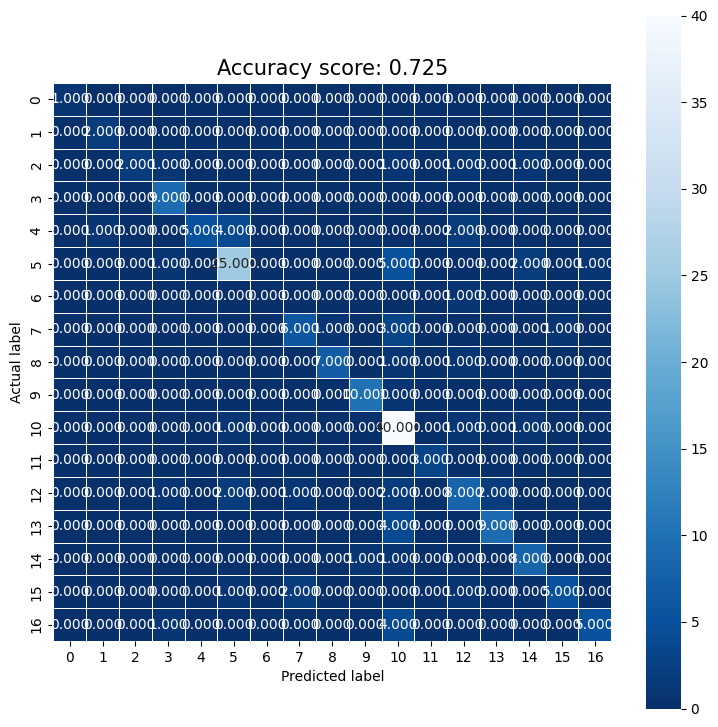

In [30]:
#Visualizing the evalutaion metrics of the model
cm=metrics.confusion_matrix(y_test,predictions)
print(cm)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square=True, cmap="Blues_r");
plt.ylabel("Actual label");
plt.xlabel("Predicted label")
all_sample_title="Accuracy score: {0}".format(score)
plt.title(all_sample_title,size=15)
plt.show()

In [31]:
#2. Decision Tree Classifier
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size = 0.2, random_state = 42)

In [32]:
#Vectorizing the dataset
vectoriser = CountVectorizer()
vectoriser.fit(X_train)
print(f'Vectoriser fitted.')
print('No. of feature_words: ', len(vectoriser.get_feature_names_out()))

Vectoriser fitted.
No. of feature_words:  707


In [33]:
# Transforming the training and testing data into feature vectors
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)
print(f'Data Transformed.')

Data Transformed.


In [34]:
#Training the model
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [35]:
#Making predictions
predictions=clf.predict(X_test)

In [36]:
#Printing the accuracy of the model
score=clf.score(X_test,y_test)
print(score*100)

78.5


In [37]:
#Evaluating the model
print("Accuracy:",metrics.accuracy_score(y_test, predictions))
print(metrics.classification_report(y_test,predictions))

Accuracy: 0.785
                          precision    recall  f1-score   support

                   Abuse       1.00      1.00      1.00         1
               Addiction       0.50      0.50      0.50         2
        Anger Management       1.00      0.67      0.80         6
                 Anxiety       0.75      1.00      0.86         9
       Behavioral Change       0.91      0.83      0.87        12
              Depression       0.86      0.74      0.79        34
       Domestic Violence       1.00      1.00      1.00         1
         Family Conflict       0.50      0.45      0.48        11
                   LGBTQ       0.88      0.78      0.82         9
      Legal & Regulatory       0.91      0.91      0.91        11
Relationship Dissolution       0.65      0.91      0.76        43
              Self Abuse       1.00      1.00      1.00         3
      Self-esteem Issues       0.85      0.69      0.76        16
           Sexual Issues       1.00      0.69      0.82    

[[ 1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0]
 [ 0  0  4  0  0  0  0  0  0  0  1  0  0  0  1  0  0]
 [ 0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 10  0  0  0  0  0  2  0  0  0  0  0  0]
 [ 0  0  0  1  1 25  0  1  0  0  5  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  5  1  0  3  0  0  0  0  1  1]
 [ 0  0  0  0  0  0  0  0  7  0  1  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 10  1  0  0  0  0  0  0]
 [ 0  0  0  0  0  2  0  1  0  0 39  0  0  0  0  0  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  2  0  0  2  0 11  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  4  0  0  9  0  0  0]
 [ 0  0  0  1  0  0  0  0  0  1  0  0  0  0  8  0  0]
 [ 0  0  0  0  0  1  0  1  0  0  1  0  0  0  0  6  0]
 [ 0  1  0  1  0  0  0  0  0  0  0  0  0  0  0  0  8]]


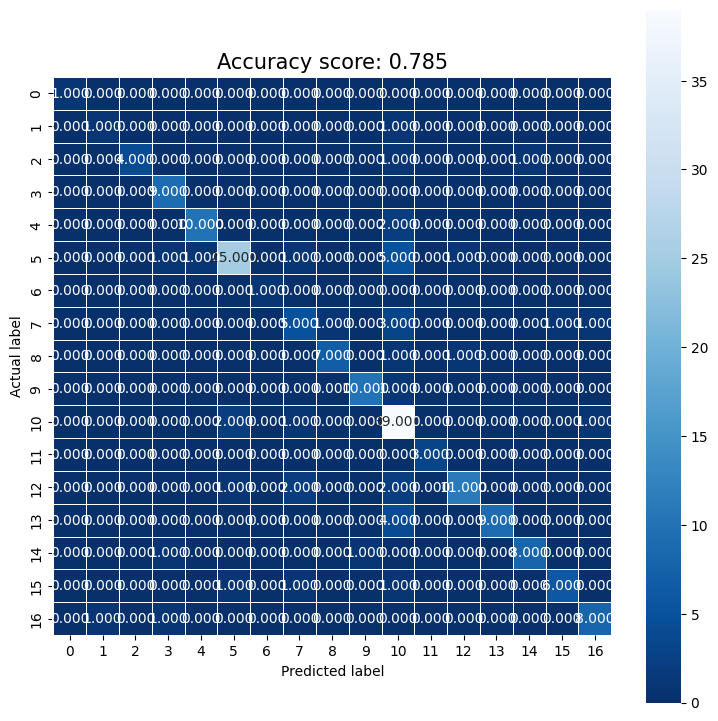

In [38]:
#Visualizing the evaluation metrics
cm=metrics.confusion_matrix(y_test,predictions)
print(cm)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square=True, cmap="Blues_r");
plt.ylabel("Actual label");
plt.xlabel("Predicted label")
all_sample_title="Accuracy score: {0}".format(score)
plt.title(all_sample_title,size=15)
plt.show()

In [39]:
#3. Random Forest Classifier
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])

Training samples: 799
Testing samples: 200


In [40]:
#Vectorizing the model
vectoriser = CountVectorizer()
vectoriser.fit(X_train)
print(f'Vectoriser fitted.')
print('No. of feature_words:', len(vectoriser.get_feature_names_out()))

Vectoriser fitted.
No. of feature_words: 707


In [41]:
# Transforming the training and testing data into feature vectors
X_train = vectoriser.transform(X_train)
X_test = vectoriser.transform(X_test)
print(f'Data Transformed.')

Data Transformed.


In [42]:
#Training the model
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [43]:
#Making predictions
predictions = clf.predict(X_test)
score = clf.score(X_test, y_test)

In [44]:
#Evaluatingg the model
print("Accuracy (Score):", score * 100)
print("Accuracy (metrics):", metrics.accuracy_score(y_test, predictions))
print(metrics.classification_report(y_test, predictions))

Accuracy (Score): 78.5
Accuracy (metrics): 0.785
                          precision    recall  f1-score   support

                   Abuse       1.00      1.00      1.00         1
               Addiction       1.00      0.50      0.67         2
        Anger Management       1.00      0.67      0.80         6
                 Anxiety       0.69      1.00      0.82         9
       Behavioral Change       1.00      0.83      0.91        12
              Depression       0.87      0.76      0.81        34
       Domestic Violence       0.50      1.00      0.67         1
         Family Conflict       0.71      0.45      0.56        11
                   LGBTQ       0.88      0.78      0.82         9
      Legal & Regulatory       0.91      0.91      0.91        11
Relationship Dissolution       0.62      0.93      0.74        43
              Self Abuse       1.00      1.00      1.00         3
      Self-esteem Issues       0.85      0.69      0.76        16
           Sexual Issues  

Confusion Matrix:
 [[ 1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0]
 [ 0  0  4  0  0  0  0  0  0  0  1  0  0  0  1  0  0]
 [ 0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 10  0  0  0  0  0  2  0  0  0  0  0  0]
 [ 0  0  0  1  0 26  0  1  0  0  5  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  5  1  0  4  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  0  0  7  0  2  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 10  1  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  1  0  0  0 40  0  0  0  0  0  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0]
 [ 0  0  0  1  0  1  0  0  0  0  3  0 11  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  3  0  0 10  0  0  0]
 [ 0  0  0  1  0  0  0  0  0  1  0  0  0  0  8  0  0]
 [ 0  0  0  0  0  1  0  1  0  0  0  0  1  0  0  6  0]
 [ 0  0  0  1  0  1  0  0  0  0  3  0  0  0  0  0  5]]


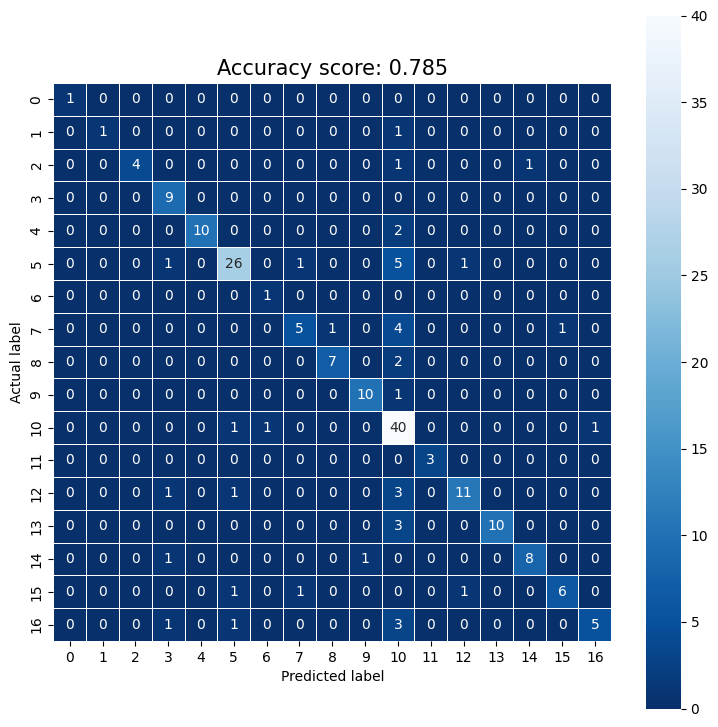

In [45]:
#Visualizing the evaluating metrics of the model
cm = metrics.confusion_matrix(y_test, predictions)
print("Confusion Matrix:\n", cm)
plt.figure(figsize=(9, 9))
sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, square=True, cmap="Blues_r")
plt.ylabel("Actual label")
plt.xlabel("Predicted label")
all_sample_title = "Accuracy score: {0}".format(score)
plt.title(all_sample_title, size=15)
plt.show()

In [46]:
# 4. SVM
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)


In [47]:
# Vectorizing the train and test data
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)


In [48]:
#Training the model and making predictions
svm_model = SVC(kernel='linear')
svm_model.fit(X_train_tfidf, y_train)
y_pred = svm_model.predict(X_test_tfidf)

In [49]:
# Evaluating the model
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.73
Classification Report:
                           precision    recall  f1-score   support

                   Abuse       1.00      1.00      1.00         1
               Addiction       0.80      0.80      0.80         5
        Anger Management       0.67      0.40      0.50         5
                 Anxiety       0.87      0.93      0.90        14
       Behavioral Change       0.57      0.67      0.62         6
              Depression       0.61      0.61      0.61        23
       Domestic Violence       0.00      0.00      0.00         1
         Family Conflict       0.73      0.50      0.59        16
                   Grief       0.00      0.00      0.00         1
                   LGBTQ       0.88      0.58      0.70        12
      Legal & Regulatory       1.00      1.00      1.00        11
Relationship Dissolution       0.68      0.91      0.78        45
              Self Abuse       1.00      1.00      1.00         1
      Self-esteem Issues       0.57 

C:\Users\aswal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\aswal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\aswal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Confusion Matrix:
 [[ 1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  4  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  2  0  0  0  0  1  0  0  0  2  0  0  0  0  0  0]
 [ 0  0  0 13  0  0  0  0  0  0  0  1  0  0  0  0  0  0]
 [ 0  0  0  0  4  0  0  0  0  0  0  1  0  0  0  0  0  1]
 [ 0  0  0  1  2 14  0  0  0  0  0  2  0  4  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  1  0  0  0  3  0  8  0  0  0  3  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  7  0  2  0  1  2  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 11  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  1  0  1  0  1  0 41  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0]
 [ 0  0  0  1  1  4  0  0  0  0  0  4  0 12  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 10  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  2  0  1  1 10  0  0]
 [ 0  0  0  0  0  1  0  1  0  0  0  0  0  0  0  0  6  0]
 [ 0  0  0  

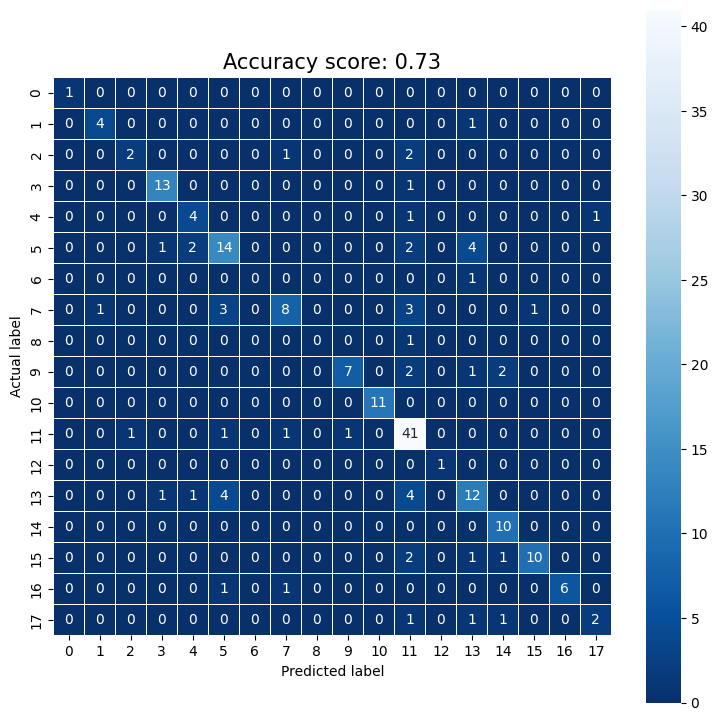

In [50]:
# Plotting the confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)
score = metrics.accuracy_score(y_test, y_pred)
plt.figure(figsize=(9, 9))
sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, square=True, cmap="Blues_r")
plt.ylabel("Actual label")
plt.xlabel("Predicted label")
all_sample_title = "Accuracy score: {0:.2f}".format(score)
plt.title(all_sample_title, size=15)
plt.show()

In [51]:
# 5. BERT
X = data['preprocessed_complaints']
Y = data['types']

In [52]:
# Encoding labels
label_encoder = LabelEncoder()
Y_encoded = label_encoder.fit_transform(Y)

In [53]:
# Splitting the dataset for train-test of the model
X_train, X_test, y_train, y_test = train_test_split(X, Y_encoded, test_size=0.2, random_state=42)

In [54]:
# Loading BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [55]:
# Tokenizing the inputs
train_encodings = tokenizer(X_train.tolist(), truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(X_test.tolist(), truncation=True, padding=True, max_length=512)

In [56]:
# Creating a dataset class
class ComplaintsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)  # Ensure labels are long type
        return item

    def __len__(self):
        return len(self.labels)

In [57]:
# Creating dataset instances
train_dataset = ComplaintsDataset(train_encodings, y_train)
test_dataset = ComplaintsDataset(test_encodings, y_test)

In [58]:
# Loading the BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [59]:
pip install transformers[torch]


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [60]:
# Setting up training arguments
training_args = TrainingArguments(
    output_dir='./results',          
    num_train_epochs=3,              
    per_device_train_batch_size=8,   
    per_device_eval_batch_size=8,    
    warmup_steps=500,                 
    weight_decay=0.01,                
    logging_dir='./logs',            
    logging_steps=10,
    evaluation_strategy="epoch",   
)

C:\Users\aswal\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [61]:
# Initializing the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

In [62]:
# Training the model
trainer.train()

Epoch,Training Loss,Validation Loss
1,2.695500,2.681144
2,2.122600,2.154120
3,1.405600,1.674683


TrainOutput(global_step=300, training_loss=2.364622189203898, metrics={'train_runtime': 565.5207, 'train_samples_per_second': 4.239, 'train_steps_per_second': 0.53, 'total_flos': 23407609009374.0, 'train_loss': 2.364622189203898, 'epoch': 3.0})

In [63]:
# Making predictions
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)

In [64]:
#Printing the accuracy
accuracy = accuracy_score(y_test, preds)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, preds))

Accuracy: 0.58
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         6
           3       0.75      1.00      0.86         9
           4       0.00      0.00      0.00        12
           6       0.50      0.79      0.61        34
           7       0.00      0.00      0.00         1
           8       0.54      0.64      0.58        11
          10       0.00      0.00      0.00         9
          11       0.65      1.00      0.79        11
          12       0.54      0.93      0.68        43
          13       0.00      0.00      0.00         3
          14       0.80      0.50      0.62        16
          15       1.00      0.15      0.27        13
          16       0.58      0.70      0.64        10
          17       1.00      0.33      0.50         9
          18       1.00      0.20      0.3

C:\Users\aswal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\aswal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\aswal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

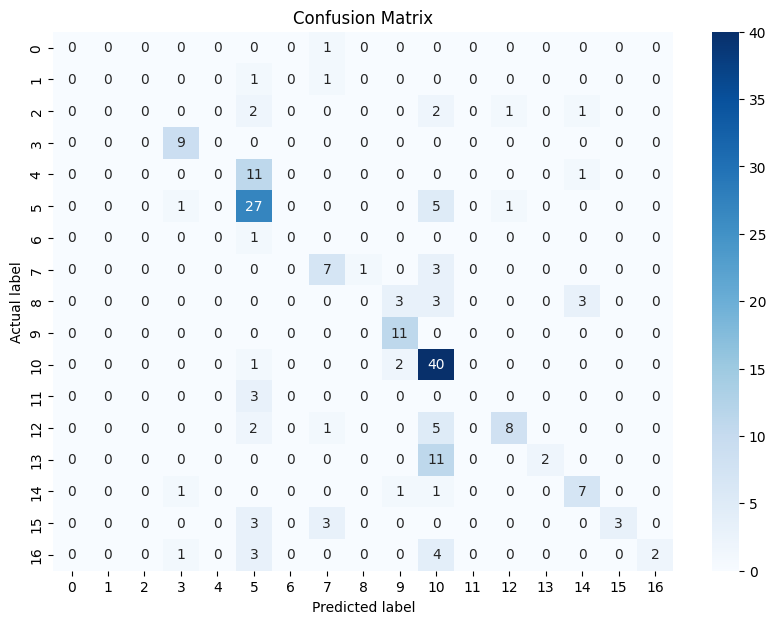

In [65]:
# Visualization of the confusion matrix
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.ylabel("Actual label")
plt.xlabel("Predicted label")
plt.title("Confusion Matrix")
plt.show()

In [66]:
# Assuming `data` is your dataset containing 'preprocessed_complaints' and 'types' columns
X = data['preprocessed_complaints']
Y = data['types']

# Encode the labels
label_encoder = LabelEncoder()
Y_encoded = label_encoder.fit_transform(Y)
num_labels = len(set(Y_encoded))  # Dynamically determine the number of labels

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, Y_encoded, test_size=0.2, random_state=42)

In [67]:
# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


In [68]:
# Tokenize the inputs
train_encodings = tokenizer(X_train.tolist(), truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(X_test.tolist(), truncation=True, padding=True, max_length=512)


In [69]:
# Create a dataset class
class ComplaintsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)


In [70]:
# Creating dataset instances
train_dataset = ComplaintsDataset(train_encodings, y_train)
test_dataset = ComplaintsDataset(test_encodings, y_test)

In [71]:
# Loading the pre-trained BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [72]:
# Defining training arguments for BERT fine-tuning
training_args = TrainingArguments(
    output_dir='./results',          
    num_train_epochs=3,              
    per_device_train_batch_size=8,   
    per_device_eval_batch_size=8,    
    warmup_steps=500,                 
    weight_decay=0.01,                
    logging_dir='./logs',            
    logging_steps=10,
    evaluation_strategy="epoch",     
)

C:\Users\aswal\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [73]:
# Initializing the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

In [74]:
# Training the BERT model (fine-tuning)
trainer.train()

Epoch,Training Loss,Validation Loss
1,2.729300,2.660496
2,2.142800,2.131043
3,1.457100,1.633163


TrainOutput(global_step=300, training_loss=2.382033945719401, metrics={'train_runtime': 574.4552, 'train_samples_per_second': 4.173, 'train_steps_per_second': 0.522, 'total_flos': 23407609009374.0, 'train_loss': 2.382033945719401, 'epoch': 3.0})

In [75]:
# Creating a function to extract BERT embeddings
def get_bert_embeddings(texts):
    encodings = tokenizer(texts, truncation=True, padding=True, max_length=512, return_tensors="pt")
    with torch.no_grad():
        outputs = model.bert(**encodings)
    return outputs.last_hidden_state[:, 0, :].numpy()  # Take CLS token embeddings

In [76]:
# Extracting embeddings for both train and test sets
X_train_bert = get_bert_embeddings(X_train.tolist())
X_test_bert = get_bert_embeddings(X_test.tolist())

In [77]:
# Combining the SVM with BERT embeddings
svm_model = SVC(kernel='linear')
svm_model.fit(X_train_bert, y_train)

SVC(kernel='linear')

In [78]:
# Making predictions using SVM
y_pred_svm = svm_model.predict(X_test_bert)

In [79]:
# Evaluating the SVM model
print("SVM-BERT Model Accuracy:", metrics.accuracy_score(y_test, y_pred_svm))
print("SVM-BERT Classification Report:\n", metrics.classification_report(y_test, y_pred_svm))
print("SVM Confusion Matrix:\n", metrics.confusion_matrix(y_test, y_pred_svm))

SVM-BERT Model Accuracy: 0.805
SVM-BERT Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      0.50      0.67         2
           2       0.80      0.67      0.73         6
           3       0.75      1.00      0.86         9
           4       0.82      0.75      0.78        12
           6       0.83      0.74      0.78        34
           7       0.50      1.00      0.67         1
           8       0.60      0.55      0.57        11
          10       0.80      0.89      0.84         9
          11       0.92      1.00      0.96        11
          12       0.79      0.88      0.84        43
          13       1.00      1.00      1.00         3
          14       0.85      0.69      0.76        16
          15       1.00      0.92      0.96        13
          16       0.67      0.80      0.73        10
          17       0.86      0.67      0.75         9
          18     

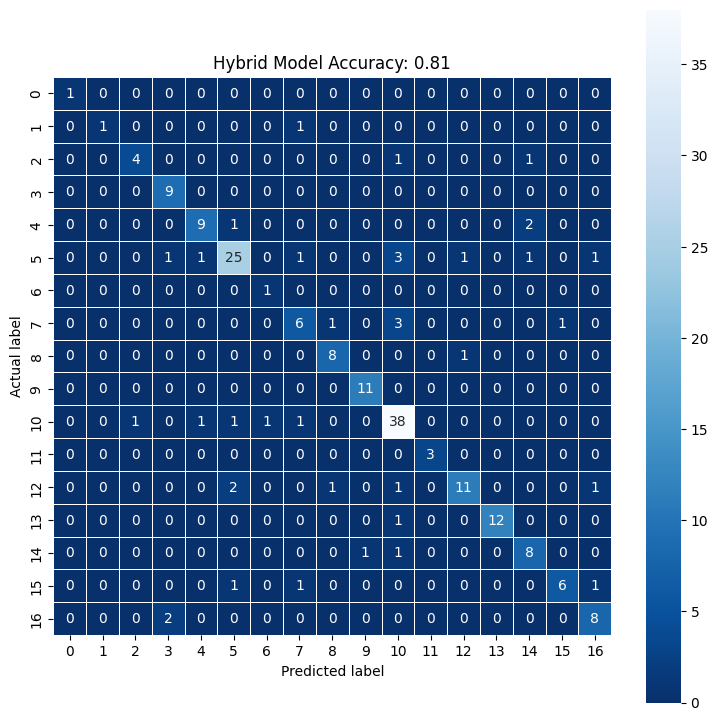

In [80]:
# Visualizing the confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(9, 9))
sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, square=True, cmap="Blues_r")
plt.ylabel("Actual label")
plt.xlabel("Predicted label")
plt.title(f"Hybrid Model Accuracy: {metrics.accuracy_score(y_test, y_pred_svm):.2f}")
plt.show()

In [81]:
#Comparing TD-IDF+SVM
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)


In [82]:
# Training SVM on TF-IDF features
svm_tfidf_model = SVC(kernel='linear')
svm_tfidf_model.fit(X_train_tfidf, y_train)

SVC(kernel='linear')

In [83]:
# Predicting and evaluating the model
y_pred_tfidf = svm_tfidf_model.predict(X_test_tfidf)
print("TF-IDF SVM Accuracy:", metrics.accuracy_score(y_test, y_pred_tfidf))
print("TF-IDF Classification Report:\n", metrics.classification_report(y_test, y_pred_tfidf))
print("TF-IDF Confusion Matrix:\n", metrics.confusion_matrix(y_test, y_pred_tfidf))

TF-IDF SVM Accuracy: 0.78
TF-IDF Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      0.50      0.67         2
           2       0.80      0.67      0.73         6
           3       0.75      1.00      0.86         9
           4       1.00      0.67      0.80        12
           6       0.84      0.79      0.82        34
           7       0.00      0.00      0.00         1
           8       0.67      0.55      0.60        11
          10       0.88      0.78      0.82         9
          11       0.91      0.91      0.91        11
          12       0.66      0.91      0.76        43
          13       1.00      1.00      1.00         3
          14       0.64      0.56      0.60        16
          15       1.00      0.92      0.96        13
          16       0.82      0.90      0.86        10
          17       0.86      0.67      0.75         9
          18       0.83 

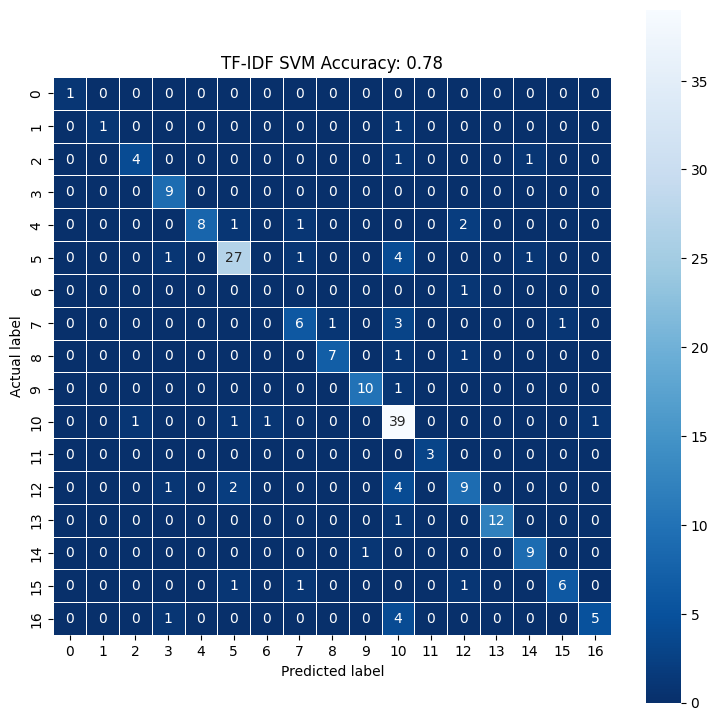

In [84]:
# Visualizing confusion matrix for TF-IDF
cm_tfidf = metrics.confusion_matrix(y_test, y_pred_tfidf)
plt.figure(figsize=(9, 9))
sns.heatmap(cm_tfidf, annot=True, fmt="d", linewidths=.5, square=True, cmap="Blues_r")
plt.ylabel("Actual label")
plt.xlabel("Predicted label")
plt.title(f"TF-IDF SVM Accuracy: {metrics.accuracy_score(y_test, y_pred_tfidf):.2f}")
plt.show()